In [2]:
import psutil
import os

In [3]:
%run Basic\ PSO.ipynb

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs

FINAL:
[-2.932409730142108, -0.9250482715202336]
11.431602085679113


In [4]:
%time
initial=[5,5]               # initial starting location [x1,x2...]
bounds=[(-10,10),(-10,10)]  # input bounds [(x1_min,x1_max),(x2_min,x2_max)...]
PSO(error,initial,bounds,num_particles=15,maxiter=30)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs

FINAL:
[2.0384014335388407, 0.08796728502754902]
5.941473232297106


In [5]:
# %load cuda_code/final/test_functions.py


from __future__ import division
import numpy as np
from scipy.optimize import minimize
from numpy import abs, cos, exp, mean, pi, prod, sin, sqrt, sum
import math,pylab


### Sphere Function

def sphere( x ):
    x = np.asarray_chkfinite(x)
    return sum( x**2 )


### Rosenbrock (Multimodal) Function

def rosen(x):
    """
    The Rosenbrock's function of N variables
    f(x) =  100*(x_i - x_{i-1}^2)^2 + (1- x_{1-1}^2)
    """

    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)


### Rastrigin Function

def rastrigin( x ):  # rast.m
    x = np.asarray_chkfinite(x)
    n = len(x)
    return 10*n + sum( x**2 - 10 * cos( 2 * pi * x ))


### Griewangk Function

def griewank( x, fr=4000 ):
    x = np.asarray_chkfinite(x)
    n = len(x)
    j = np.arange( 1., n+1 )
    s = sum( x**2 )
    p = prod( cos( x / sqrt(j) ))
    return s/fr - p + 1


### Ackley Function

def ackley( x, a=20, b=0.2, c=2*pi ):
    x = np.asarray_chkfinite(x)  # ValueError if any NaN or Inf
    n = len(x)
    s1 = sum( x**2 )
    s2 = sum( cos( c * x ))
    return -a*exp( -b*sqrt( s1 / n )) - exp( s2 / n ) + a + exp(1)


### Weierstrass Function

def wer(a, x, e): # a is givin number, e is error tolerance

    Sum1 = 0
    Sum2 = 0
    k = 1

    while(True):
        #sine of pi times k to the a times x over pi times k to the a
        Sum1 = math.sin((math.pi)*pow(k,a)*(x))/((math.pi)*(pow(k,a)))
        Sum2 = Sum1 + math.sin((math.pi)*pow((k+1),a)*(x))/((math.pi)*pow((k+1),a))

        if (abs(Sum2-Sum1) < e):
            break
        else:
            k+=1
    return Sum1

def append(x0, xf, n):

    xl = [] #list containing x values
    yl = [] #corresponding y values
    dx = (xf-x0)/n #length of each subinterval

    for i in range (0, (n+1)):
        xval = x0 + (i * dx)
        yval = wer(a, xval, e) #ERROR HERE

        xl.append(xval)
        yl.append(yval)
        #print i,':',xl
    return xl, yl

# xl,yl=0,0
# xl,yl = append(x0, xf, n)   
# pylab.plot(xl,yl)


### Zakharov Function


def zakharov( x ):  # zakh.m
    x = np.asarray_chkfinite(x)
    n = len(x)
    j = np.arange( 1., n+1 )
    s2 = sum( j * x ) / 2
    return sum( x**2 ) + s2**2 + s2**4


# ### Non-Continuous Rastrigin Function

def nonContinuousRastrigin(x):
    y=[]
    for i in range(len(x)):
        temp=0
        if(abs(x[i]) <= 0.5):
            temp = x[i]
        else:
             temp = (2*x[i]+0.5)/2
        y.append(temp)
    y = np.asarray_chkfinite(y)
    n=len(x); A=10.
    return 10*n + sum( y**2 - 10 * cos( 2 * pi * y ))



class BenchMark():

	def __init__(self):
		pass


### Bounds for different funcitons:
 

# - ackley._bounds       = [-15, 30]
# - dixonprice._bounds   = [-10, 10]
# - griewank._bounds     = [-600, 600]
# - levy._bounds         = [-10, 10]
# - michalewicz._bounds  = [0, pi]
# - perm._bounds         = ["-dim", "dim"]  # min at [1 2 .. n]
# - powell._bounds       = [-4, 5]  # min at tile [3 -1 0 1]
# - powersum._bounds     = [0, "dim"]  # 4d min at [1 2 3 4]
# - rastrigin._bounds    = [-5.12, 5.12]
# - rosenbrock._bounds   = [-2.4, 2.4]  # wikipedia
# - schwefel._bounds     = [-500, 500]
# - sphere._bounds       = [-5.12, 5.12]
# - sum2._bounds         = [-10, 10]
# - trid._bounds         = ["-dim**2", "dim**2"]  # fmin -50 6d, -200 10d
# - zakharov._bounds     = [-5, 10]
# 
# - ellipse._bounds      =  [-2, 2]
# - logsumexp._bounds    = [-20, 20]  # ?
# - nesterov._bounds     = [-2, 2]
# - powellsincos._bounds = [ "-20*pi*dim", "20*pi*dim"]
# - randomquad._bounds   = [-10000, 10000]
# - saddle._bounds = [-3, 3]


In [6]:
# %load cuda_code/final/evaluate.py
from init_particles import create_n_particles
from numba import jit
import math
import random

def rosen(x):
    """
    The Rosenbrock's function of N variables
    f(x) =  100*(x_i - x_{i-1}^2)^2 + (1- x_{1-1}^2)
    """

    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

def rastrigin( x ):  # rast.m
    x = np.asarray_chkfinite(x)
    n = len(x)
    return 10*n + sum( x**2 - 10 * cos( 2 * pi * x ))

@jit(debug=True)
def error(position):
    err = rosen(position)
    return err

@jit
def evaluate(costFunc, p):
    p['err_i'] = costFunc(p['position_i'])
    # check to see if the current position is an individual best
    if p['err_i'] < p['err_best_i'] or p['err_best_i']==-1:
        p['pos_best_i'] = p['position_i']
        p['err_best_i'] = p['err_i']
    return p['pos_best_i'], p['err_best_i']

@jit
def update_velocity(pos_best_g, p):
    w=0.5       # constant inertia weight (how much to weigh the previous velocity)
    c1=1        # cognative constant
    c2=2        # social constant

    for i in range(0, p['num_dimensions']):
        r1=random.random()
        r2=random.random()

        vel_cognitive=c1*r1*(p['pos_best_i'][0][i]-p['position_i'][0][i])
        vel_social=c2*r2*(pos_best_g[0][i]-p['position_i'][0][i])
        p['velocity_i'][0][i]=w*p['velocity_i'][0][i]+vel_cognitive+vel_social
    return p['velocity_i']

@jit
def update_position(bounds, p):
    for i in range(0, p['num_dimensions']):
        p['position_i'][0][i]=p['position_i'][0][i]+p['velocity_i'][0][i]

        # adjust maximum position if necessary
        if p['position_i'][0][i]>bounds[i][1]:
            p['position_i'][0][i]=bounds[i][1]

        # adjust minimum position if neseccary
        if p['position_i'][0][i] < bounds[i][0]:
            p['position_i'][0][i]=bounds[i][0]
    return p['position_i']



if __name__ == '__main__':
    bounds=[(-10,10),(-10,10)]
    particles = create_n_particles(100, 2, bounds)
#     evaluate(error, particles[0])
    pos_best_g = particles[0]['position_i']
    update_velocity(pos_best_g, particles[1])
#     update_position(bounds, particles[1])


In [7]:
from multiprocessing import Manager, Process, Lock
from init_particles import create_n_particles
from numba import jit
import numpy as np


@jit
def PSO_purana(costFunc,bounds,maxiter,swarm_init=None):
        
    num_dimensions=len(swarm_init[0])
    err_best_g=-1                   # best error for group
    pos_best_g=[]                   # best position for group
    num_particles = len(swarm_init)
    # establish the swarm
    swarm = create_n_particles(num_particles, num_dimensions, swarm_init)
    # begin optimization loop
    i=0
    while i < maxiter:
        #print i,err_best_g
        # cycle through particles in swarm and evaluate fitness
        for j in range(0,num_particles):
            swarm[j]['pos_best_i'], swarm[j]['err_best_i']  = evaluate(costFunc, swarm[j])

            # determine if current particle is the best (globally)
            if swarm[j]['err_i'] < err_best_g or err_best_g == -1:
                pos_best_g=list(swarm[j]['position_i'])
                err_best_g=float(swarm[j]['err_i'])

        # cycle through swarm and update velocities and position
        for j in range(0,num_particles):
            swarm[j]['velocity_i'] = update_velocity(pos_best_g, swarm[j])
            swarm[j]['position_i'] = update_position(bounds, swarm[j])
        i+=1

    # print final results
    #print ('\n')
    #print (pos_best_g,' , ', err_best_g)
    return pos_best_g[0], err_best_g

@jit
def PSO(costFunc,bounds,maxiter,shared_list, return_list, l,num_particles=None,swarm_init=None):

    
#     if num_particles is not None:
#         dims = len(bounds)
#         lb = bounds[0][0] 
#         ub = bounds[0][1]
#         swarm_init = []
#         for _ in range(num_particles):
#             swarm_init.append(np.random.uniform(lb, ub, dims))
        
    num_dimensions=len(swarm_init[0])
    err_best_g=-1                   # best error for group
    pos_best_g=[]                   # best position for group
    num_particles = len(swarm_init)
    # establish the swarm
    swarm = create_n_particles(num_particles, num_dimensions, swarm_init)
    # begin optimization loop
    i=0
    while i < maxiter:
        #print i,err_best_g
        # cycle through particles in swarm and evaluate fitness
        for j in range(0,num_particles):
            swarm[j]['pos_best_i'], swarm[j]['err_best_i']  = evaluate(costFunc, swarm[j])

            # determine if current particle is the best (globally)
            if swarm[j]['err_i'] < err_best_g or err_best_g == -1:
                pos_best_g=list(swarm[j]['position_i'])
                err_best_g=float(swarm[j]['err_i'])
        
        # update the global best in the manager list after k iterations
        # we need to add some mutex lock here
        
        if i == max_iter//2:
            l.acquire()
            best_galactic_pos = shared_list[0]
            best_galactic_err = shared_list[1]
            #print("best_galactic_err: " ,best_galactic_err)
            #print("best_galactic_pos: ", best_galactic_pos)
            if err_best_g < best_galactic_err:
                shared_list[1] = err_best_g
                #print(err_best_g)
                shared_list[0] = pos_best_g
            else:
                #print("changing pos_best_g from", pos_best_g, " to ", best_galactic_pos)
                #emp_list = []
                err_best_g = float(best_galactic_err)
                #emp_list.append(best_galactic_pos)
                pos_best_g = [best_galactic_pos]
            
            l.release()
        # cycle through swarm and update velocities and position
        for j in range(0,num_particles):
            swarm[j]['velocity_i'] = update_velocity(pos_best_g, swarm[j])
            swarm[j]['position_i'] = update_position(bounds, swarm[j])
        i+=1
    return_list.append(pos_best_g[0])


def start(process_list):
    for p in process_list:
        p.start()
        
def stop(process_list):
    for p in process_list:
        p.join()

@jit
def GSO(M, bounds, num_particles, max_iter):
    subswarm_bests = []
    dims = len(bounds)
    lb = bounds[0][0] 
    ub = bounds[0][1]
    manager = Manager()
    l = Lock()
    shared_list = manager.list()
    return_list = manager.list()
    shared_list = [np.random.uniform(lb, ub, dims), -1]
    all_processes = []
    for i in range(M):
        #initial= np.random.uniform(-10,10, 2)               # initial starting location [x1,x2...]         
        swarm_init = []
        for _ in range(num_particles):
            swarm_init.append(np.random.uniform(lb, ub, dims))

        p = Process(target=PSO, args=(error, bounds, max_iter, shared_list, return_list, l, None,swarm_init))
        all_processes.append(p)

    start(all_processes)
    stop(all_processes)    
    #print(return_list)
    return PSO_purana(error, bounds, max_iter, swarm_init=list(return_list))


In [8]:
M = [5, 10, 15, 20, 25, 30, 35, 40]
bounds = [[-1000, 1000], [-1000, 1000]]
num_particles = 35
max_iter = 10000
m = 5

GSO(5, bounds, num_particles, max_iter)

(array([461.54907756,  31.54675001]), 0.0)

In [9]:
import matplotlib.pyplot as plt
import numpy as np

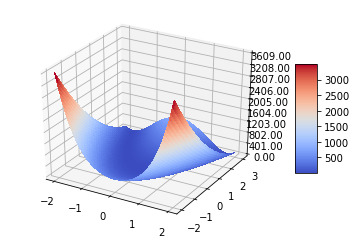

In [42]:
# rosenbrock_demo.py
#
#Python 2.7.3
#Matplotlib 1.1.1rc

#Code also works fine with Anaconda3 / matplotlib version 1.4.0!
#Code also works fine with CPython 3.4.2 + Scipy-stack-14.8.27.win32-py3.4 from
#   Christoph Gohlke's unofficial libraries:
#    http://www.lfd.uci.edu/~gohlke/pythonlibs/

#Works fine with Python3 on Ubuntu 14.04 after adding SciPy stack:
# sudo apt-get install python3-numpy python3-scipy python3-matplotlib



#This function is not used, but illustrates the Rosenbrock function with
# 2 parameters. The actual Rosenbrock function is embedded in the code below
# using array operations so that it is calculated over a meshgrid of many
# points to produce an array of many Z values.
#Rosenbrock function of 2 variables:
def rosenbrock(x,y):
      return (1-x)**2 + 100* ((y-x**2))**2
    
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plot
import numpy as np

fig = plot.figure()
ax = fig.gca(projection='3d')

s = 0.05   # Try s=1, 0.25, 0.1, or 0.05
X = np.arange(-2, 2.+s, s)   #Could use linspace instead if dividing
Y = np.arange(-2, 3.+s, s)   #evenly instead of stepping...
    
#Create the mesh grid(s) for all X/Y combos.
X, Y = np.meshgrid(X, Y)

#Rosenbrock function w/ two parameters using numpy Arrays
Z = (1.-X)**2 + 100.*(Y-X*X)**2

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
         linewidth=0, antialiased=False)  #Try coolwarm vs jet

 
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

#Displays the figure, handles user interface, returns when user closes window
plot.show()

In [54]:
x = np.array([1,2,3,4])

sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)


[1 2 3]


2705.0

In [47]:
# %load convergence_.py
# %load cuda_code/final/test_functions.py


from __future__ import division
import numpy as np
from scipy.optimize import minimize
from numpy import abs, cos, exp, mean, pi, prod, sin, sqrt, sum
import math,pylab
import psutil
import time
import os

### Sphere Function

def sphere( x ):
    x = np.asarray_chkfinite(x)
    return sum( x**2 )


### Rosenbrock (Multimodal) Function

def rosen(x):
    """
    The Rosenbrock's function of N variables
    f(x) =  100*(x_i - x_{i-1}^2)^2 + (1- x_{1-1}^2)
    """

    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)


### Rastrigin Function

def rastrigin( x ):  # rast.m
    x = np.asarray_chkfinite(x)
    n = len(x)
    return 10*n + sum( x**2 - 10 * cos( 2 * pi * x ))


### Griewangk Function

def griewank( x, fr=4000 ):
    x = np.asarray_chkfinite(x)
    n = len(x)
    j = np.arange( 1., n+1 )
    s = sum( x**2 )
    p = prod( cos( x / sqrt(j) ))
    return s/fr - p + 1


### Ackley Function

def ackley( x, a=20, b=0.2, c=2*pi ):
    x = np.asarray_chkfinite(x)  # ValueError if any NaN or Inf
    n = len(x)
    s1 = sum( x**2 )
    s2 = sum( cos( c * x ))
    return -a*exp( -b*sqrt( s1 / n )) - exp( s2 / n ) + a + exp(1)


### Weierstrass Function

def wer(a, x, e): # a is givin number, e is error tolerance

    Sum1 = 0
    Sum2 = 0
    k = 1

    while(True):
        #sine of pi times k to the a times x over pi times k to the a
        Sum1 = math.sin((math.pi)*pow(k,a)*(x))/((math.pi)*(pow(k,a)))
        Sum2 = Sum1 + math.sin((math.pi)*pow((k+1),a)*(x))/((math.pi)*pow((k+1),a))

        if (abs(Sum2-Sum1) < e):
            break
        else:
            k+=1
    return Sum1

def append(x0, xf, n):

    xl = [] #list containing x values
    yl = [] #corresponding y values
    dx = (xf-x0)/n #length of each subinterval

    for i in range (0, (n+1)):
        xval = x0 + (i * dx)
        yval = wer(a, xval, e) #ERROR HERE

        xl.append(xval)
        yl.append(yval)
        #print i,':',xl
    return xl, yl

# xl,yl=0,0
# xl,yl = append(x0, xf, n)   
# pylab.plot(xl,yl)


### Zakharov Function


def zakharov( x ):  # zakh.m
    x = np.asarray_chkfinite(x)
    n = len(x)
    j = np.arange( 1., n+1 )
    s2 = sum( j * x ) / 2
    return sum( x**2 ) + s2**2 + s2**4


# ### Non-Continuous Rastrigin Function

def nonContinuousRastrigin(x):
    y=[]
    for i in range(len(x)):
        temp=0
        if(abs(x[i]) <= 0.5):
            temp = x[i]
        else:
             temp = (2*x[i]+0.5)/2
        y.append(temp)
    y = np.asarray_chkfinite(y)
    n=len(x); A=10.
    return 10*n + sum( y**2 - 10 * cos( 2 * pi * y ))



class BenchMark():

	def __init__(self):
		pass


### Bounds for different funcitons:
 

# - ackley._bounds       = [-15, 30]
# - dixonprice._bounds   = [-10, 10]
# - griewank._bounds     = [-600, 600]
# - levy._bounds         = [-10, 10]
# - michalewicz._bounds  = [0, pi]
# - perm._bounds         = ["-dim", "dim"]  # min at [1 2 .. n]
# - powell._bounds       = [-4, 5]  # min at tile [3 -1 0 1]
# - powersum._bounds     = [0, "dim"]  # 4d min at [1 2 3 4]
# - rastrigin._bounds    = [-5.12, 5.12]
# - rosenbrock._bounds   = [-2.4, 2.4]  # wikipedia
# - schwefel._bounds     = [-500, 500]
# - sphere._bounds       = [-5.12, 5.12]
# - sum2._bounds         = [-10, 10]
# - trid._bounds         = ["-dim**2", "dim**2"]  # fmin -50 6d, -200 10d
# - zakharov._bounds     = [-5, 10]
# 
# - ellipse._bounds      =  [-2, 2]
# - logsumexp._bounds    = [-20, 20]  # ?
# - nesterov._bounds     = [-2, 2]
# - powellsincos._bounds = [ "-20*pi*dim", "20*pi*dim"]
# - randomquad._bounds   = [-10000, 10000]
# - saddle._bounds = [-3, 3]

# %load cuda_code/final/evaluate.py
from init_particles import create_n_particles
from numba import jit
import math
import random

def error(position):
    err = rosen(position)
    return err

@jit
def evaluate(costFunc, p):
    p['err_i'] = costFunc(p['position_i'])
    # check to see if the current position is an individual best
    if p['err_i'] < p['err_best_i'] or p['err_best_i']==-1:
        p['pos_best_i'] = p['position_i']
        p['err_best_i'] = p['err_i']
    return p['pos_best_i'], p['err_best_i']

@jit
def update_velocity(pos_best_g, p):
    w=0.5       # constant inertia weight (how much to weigh the previous velocity)
    c1=1        # cognative constant
    c2=2        # social constant

    for i in range(0, p['num_dimensions']):
        r1=random.random()
        r2=random.random()

        vel_cognitive=c1*r1*(p['pos_best_i'][0][i]-p['position_i'][0][i])
        vel_social=c2*r2*(pos_best_g[0][i]-p['position_i'][0][i])
        p['velocity_i'][0][i]=w*p['velocity_i'][0][i]+vel_cognitive+vel_social
    return p['velocity_i']

@jit
def update_position(bounds, p):
    for i in range(0, p['num_dimensions']):
        p['position_i'][0][i]=p['position_i'][0][i]+p['velocity_i'][0][i]

        # adjust maximum position if necessary
        if p['position_i'][0][i]>bounds[i][1]:
            p['position_i'][0][i]=bounds[i][1]

        # adjust minimum position if neseccary
        if p['position_i'][0][i] < bounds[i][0]:
            p['position_i'][0][i]=bounds[i][0]
    return p['position_i']



if __name__ == '__main__':
    bounds=[(-10,10),(-10,10)]
    particles = create_n_particles(100, 2, bounds)
#     evaluate(error, particles[0])
    pos_best_g = particles[0]['position_i']
    update_velocity(pos_best_g, particles[1])
#     update_position(bounds, particles[1])

from multiprocessing import Manager, Process, Lock
from init_particles import create_n_particles
from numba import jit
import numpy as np


@jit
def PSO_purana(costFunc,bounds,maxiter,swarm_init=None):
        
    num_dimensions=len(swarm_init[0])
    err_best_g=-1                   # best error for group
    pos_best_g=[]                   # best position for group
    num_particles = len(swarm_init)
    # establish the swarm
    swarm = create_n_particles(num_particles, num_dimensions, swarm_init)
    # begin optimization loop
    i=0
    while i < maxiter:
        #print i,err_best_g
        # cycle through particles in swarm and evaluate fitness
        for j in range(0,num_particles):
            swarm[j]['pos_best_i'], swarm[j]['err_best_i']  = evaluate(costFunc, swarm[j])

            # determine if current particle is the best (globally)
            if swarm[j]['err_i'] < err_best_g or err_best_g == -1:
                pos_best_g=list(swarm[j]['position_i'])
                err_best_g=float(swarm[j]['err_i'])

        # cycle through swarm and update velocities and position
        for j in range(0,num_particles):
            swarm[j]['velocity_i'] = update_velocity(pos_best_g, swarm[j])
            swarm[j]['position_i'] = update_position(bounds, swarm[j])
        i+=1

    # print final results
    #print ('\n')
    #print (pos_best_g,' , ', err_best_g)
    return pos_best_g[0], err_best_g

@jit
def PSO(costFunc,bounds,maxiter,shared_list, return_list, l,num_particles=None,swarm_init=None):

    
#     if num_particles is not None:
#         dims = len(bounds)
#         lb = bounds[0][0] 
#         ub = bounds[0][1]
#         swarm_init = []
#         for _ in range(num_particles):
#             swarm_init.append(np.random.uniform(lb, ub, dims))
        
    num_dimensions=len(swarm_init[0])
    err_best_g=-1                   # best error for group
    pos_best_g=[]                   # best position for group
    num_particles = len(swarm_init)
    # establish the swarm
    swarm = create_n_particles(num_particles, num_dimensions, swarm_init)
    # begin optimization loop
    i=0
    while i < maxiter:
        #print i,err_best_g
        # cycle through particles in swarm and evaluate fitness
        for j in range(0,num_particles):
            swarm[j]['pos_best_i'], swarm[j]['err_best_i']  = evaluate(costFunc, swarm[j])

            # determine if current particle is the best (globally)
            if swarm[j]['err_i'] < err_best_g or err_best_g == -1:
                pos_best_g=list(swarm[j]['position_i'])
                err_best_g=float(swarm[j]['err_i'])
        
        # update the global best in the manager list after k iterations
        # we need to add some mutex lock here
        
        if i == max_iter//2:
            l.acquire()
            best_galactic_pos = shared_list[0]
            best_galactic_err = shared_list[1]
            #print("best_galactic_err: " ,best_galactic_err)
            #print("best_galactic_pos: ", best_galactic_pos)
            if err_best_g < best_galactic_err:
                shared_list[1] = err_best_g
                #print(err_best_g)
                shared_list[0] = pos_best_g
            else:
                #print("changing pos_best_g from", pos_best_g, " to ", best_galactic_pos)
                #emp_list = []
                err_best_g = float(best_galactic_err)
                #emp_list.append(best_galactic_pos)
                pos_best_g = [best_galactic_pos]
            
            l.release()
        # cycle through swarm and update velocities and position
        for j in range(0,num_particles):
            swarm[j]['velocity_i'] = update_velocity(pos_best_g, swarm[j])
            swarm[j]['position_i'] = update_position(bounds, swarm[j])
        i+=1
    return_list.append(pos_best_g[0])


def start(process_list):
    for p in process_list:
        p.start()
        
def stop(process_list):
    for p in process_list:
        p.join()

@jit
def GSO(M, bounds, num_particles, max_iter, costfunc, tim=None):
    subswarm_bests = []
    dims = len(bounds)
    lb = bounds[0][0] 
    ub = bounds[0][1]
    manager = Manager()
    l = Lock()
    shared_list = manager.list()
    return_list = manager.list()
    shared_list = [np.random.uniform(lb, ub, dims), -1]
    all_processes = []
    for i in range(M):
        #initial= np.random.uniform(-10,10, 2)               # initial starting location [x1,x2...]         
        swarm_init = []
        for _ in range(num_particles):
            swarm_init.append(np.random.uniform(lb, ub, dims))
        
        p = Process(target=PSO, args=(costfunc, bounds, max_iter, shared_list, return_list, l, None,swarm_init))
        all_processes.append(p)
        
    pids = list()
    for Prec in all_processes:
        pids.append(Prec.pid)
    if tim is not None:
        cp_proc = Process(target=get_cpu_percent, args=(pids, tim))
        all_processes.append(cp_proc)
    start(all_processes)
    stop(all_processes)    
    return PSO_purana(error, bounds, max_iter, swarm_init=list(return_list))

def get_cpu_percent(pids, tim):
    ps_prec = list()
    ps_dict = dict()
    for i,pid in enumerate(pids):
        ps_prec.append(psutil.Process(pid))
    start_ = time.time()
    while True:
        if time.time() - start_ >= tim:
            break
        for i, prec in enumerate(ps_prec):
            if i not in ps_dict:
                ps_dict[i] = dict()
            if 'cpu_percent' not in ps_dict[i]:
                ps_dict[i]['cpu_percent'] = list()
                if 'time_at' not in ps_dict[i]:
                    ps_dict[i]['time_at'] = list()
            test = prec.cpu_percent()
            if int(test) != 0:
                ps_dict[i]['cpu_percent'].append(test)
                ps_dict[i]['time_at'].append(time.time() - start_)
            
    print(ps_dict)
    

M = [5, 10, 15, 20, 25, 30, 35, 40]
bounds = [[-100, 100], [-100, 100]]
num_particles = 50
max_iter = 1000
m = 5

# %timeit GSO(5, bounds, num_particles, max_iter, rosen, tim=None)

In [12]:
op.average

10.038848056000072

In [52]:
def monitor(target, bounds, num_particles, max_iter, costfunc):
    worker_process = Process(target=target, args=(5, bounds, num_particles, max_iter, costfunc, None))
    worker_process.start()
    p = psutil.Process(worker_process.pid)

    # log cpu usage of `worker_process` every 10 ms
    cpu_percents = [0.0]
    start = time.time()
    time_at = [0.0]
    while worker_process.is_alive():
        cpu_percents.append(p.cpu_percent()/psutil.cpu_count())
        time_at.append(time.time()-start)
        time.sleep(0.01)

    worker_process.join()
    return cpu_percents, time_at

cpu_percents, time_at = monitor(GSO, bounds, num_particles, max_iter, rosen)

In [ ]:
count=0
for k in cpu_percents:
    if k != 0.0:
        count+=1
        print(k)
print(count)
ti = 0 
for i in range(len(cpu_percents)):
    ti+=0.05
print(ti)

In [53]:
print(len(cpu_percents))
print(len(time_at))

1876
1876


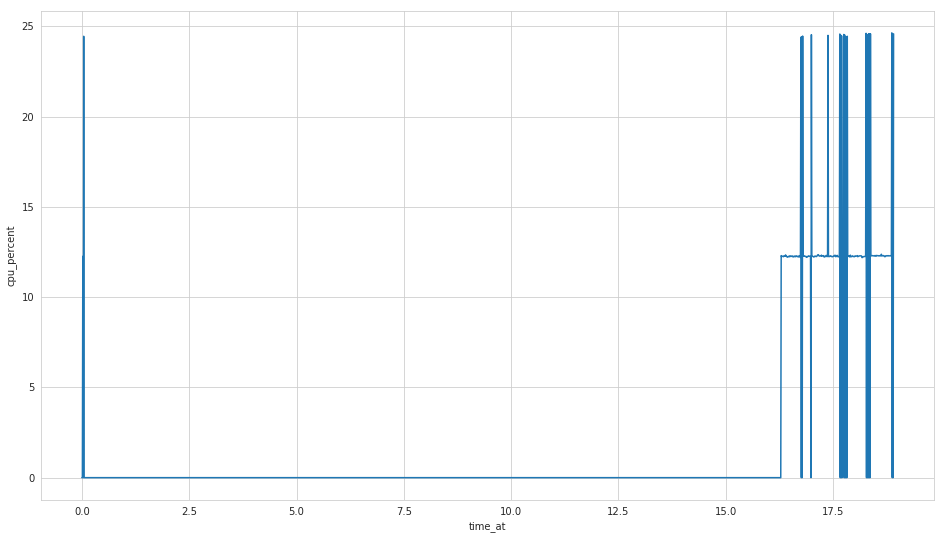

In [40]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.DataFrame.from_dict({'cpu_percent': cpu_percents, 'time_at': time_at})
plt.figure(figsize=(16,9))
sns.set_style("whitegrid")
# plt.xticks((np.arange(0, 18+1, 0.05)))
# plt.xlim(0, 18)
sns.lineplot(x='time_at', y='cpu_percent', data=df)


In [14]:
plt.figure(figsize=(16,9))

17.998923301696777

In [44]:
def regular_plot(cpu_percents, time_at):
    df = pd.DataFrame.from_dict({'cpu_percent': cpu_percents, 'time_at': time_at})
    plt.figure(figsize=(16,9))
    sns.set_style("dark")
    sns.lineplot(x='time_at', y='cpu_percent', data=df)

def zoomed_plot(cpu_percents, time_at, zoom_range, step):
    df = pd.DataFrame.from_dict({'cpu_percent': cpu_percents, 'time_at': time_at})
    plt.figure(figsize=(16,9))
    sns.set_style("dark")
    plt.xticks((np.arange(zoom_range[0], zoom_range[1]+1, step)))
    plt.xlim(zoom_range[0], zoom_range[1])
    sns.lineplot(x='time_at', y='cpu_percent', data=df)

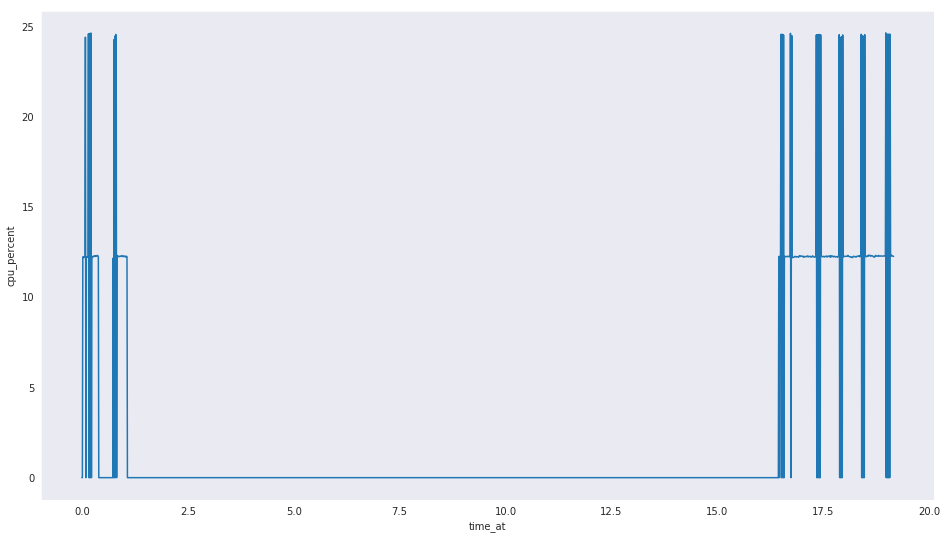

In [54]:
regular_plot(cpu_percents, time_at)

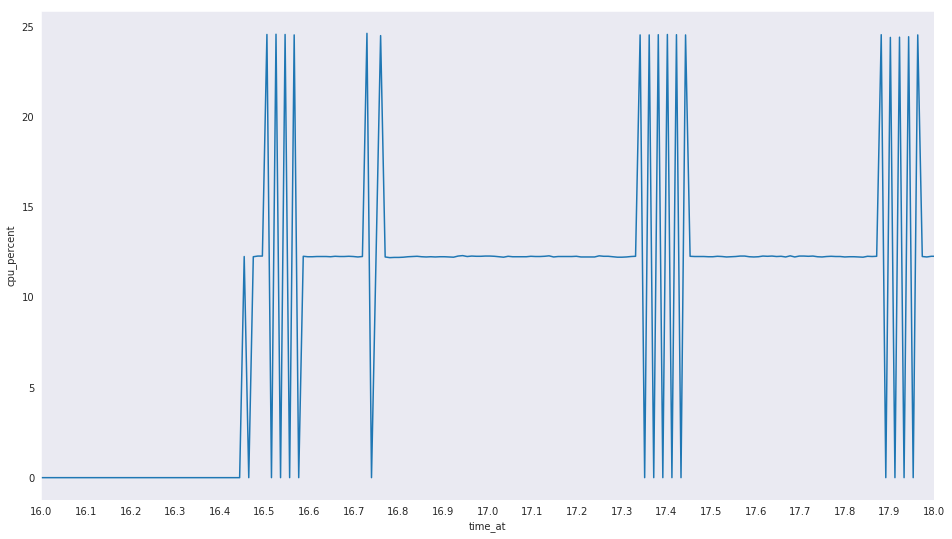

In [55]:
zoomed_plot(cpu_percents, time_at, [16, 18], 0.1)

In [56]:
M = [5, 10, 15, 20, 25, 30, 35, 40]
bounds = [[-1000, 1000], [-1000, 1000]]
num_particles = 50
max_iter = 1000

cpu_percents_rastrigin, time_at_rastrigin = monitor(GSO, bounds, num_particles, max_iter, rastrigin)

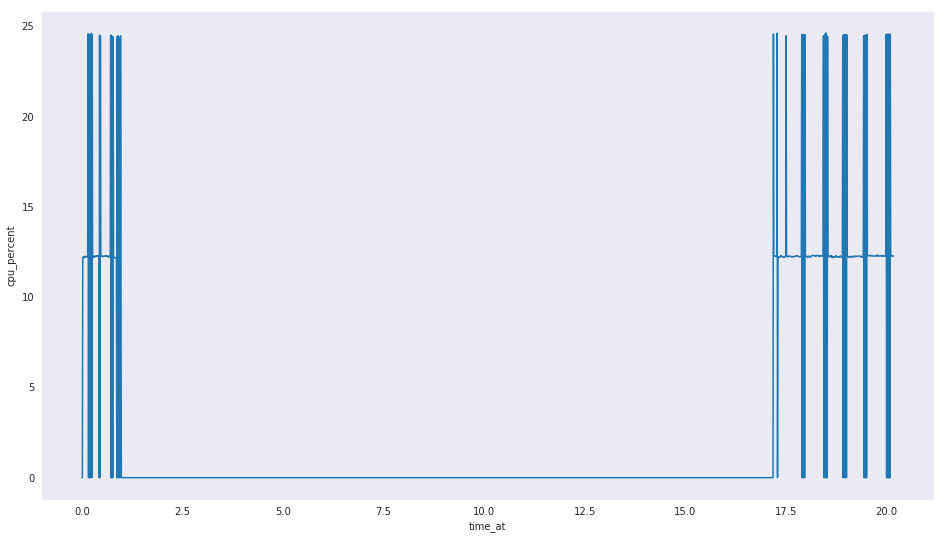

In [57]:
regular_plot(cpu_percents_rastrigin, time_at_rastrigin)

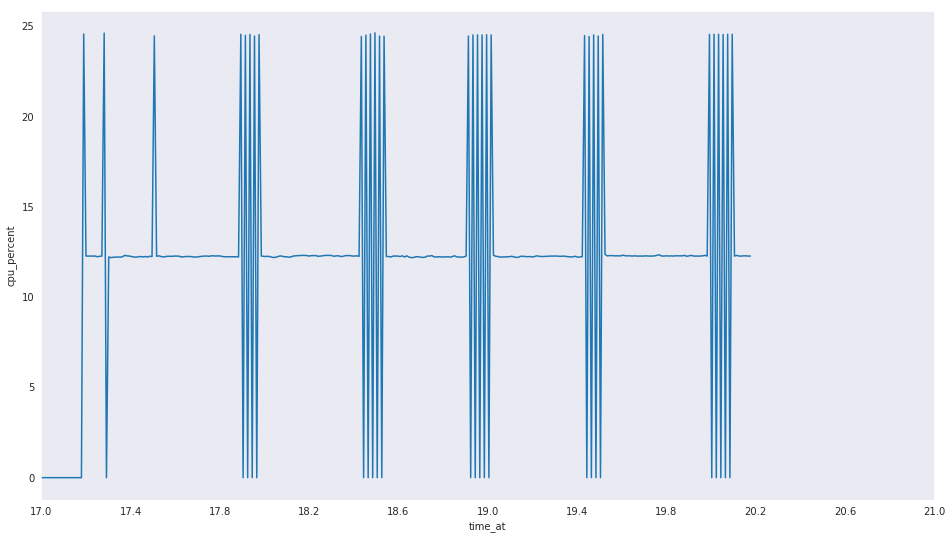

In [64]:
zoomed_plot(cpu_percents_rastrigin, time_at_rastrigin, [17, 21], 0.4)

In [65]:
max(cpu_percents_rastrigin)

24.6375

In [66]:
max(cpu_percents)

24.6625